In [1]:
import numpy as np
import scipy.stats as stats
from scipy.signal import peak_widths, find_peaks
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker


In [3]:
class DynaToy:
    def __init__(self, layer_sizes):
        self.layer_sizes = layer_sizes
        self.layers = [np.zeros([m, 1]) for m in self.layer_sizes]

        self.r = np.concatenate(self.layers)
        self.W = np.zeros([len(self.r), len(self.r)])

        self.in_idx = np.arange(0, layer_sizes[0])
        self.out_idx = np.arange(len(self.r) - layer_sizes[-1], len(self.r))

    
    def init_weights(self, kappas = [], plot = False):
        W = np.zeros_like(self.W)

        if not kappas:
            self.kappas = [1 for i in range(len(self.layer_sizes))]
        else:
            self.kappas = kappas

        for i in range(len(self.layer_sizes) - 1):
            rstart = int(np.sum(self.layer_sizes[:(i+1)]))
            rstop = rstart + self.layer_sizes[i+1]

            cstart = int(np.sum(self.layer_sizes[:i]))
            cstop = cstart + self.layer_sizes[i]

            shape = (self.layer_sizes[i+1], self.layer_sizes[i])

            W_l = np.zeros(shape)
            x = np.linspace(0, 2*np.pi, shape[1])

            for ii in range(shape[0]):
                loc = ((ii/shape[0]) * 2*np.pi)
                rf = stats.vonmises.pdf(x, self.kappas[i], loc)
                rf /= np.linalg.norm(rf)
                W_l[ii, :] = rf
            
            W[rstart:rstop, cstart:cstop] = W_l
            W[cstart:cstop, rstart:rstop] = W_l.T

        if plot:
            plt.imshow(W)
            plt.title("Model Weights")

        return W
    

    def step(self, r):    
        self.r = self.W @ r
        self.r /= np.linalg.norm(self.r)
        # self.r /= self.r.max()
        
        return self.r




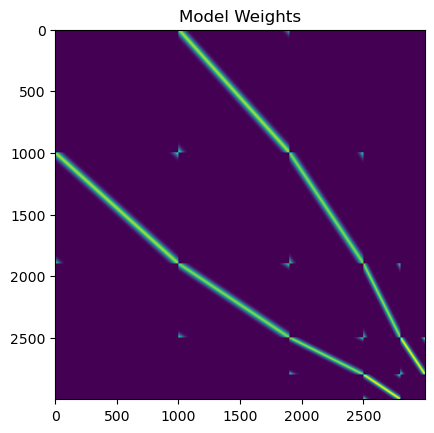

In [8]:
layer_sizes = [1000, 900, 600, 300, 200]
kappas = [30, 20, 10, 5]
n_timesteps = 30
# kappas = []


model = DynaToy(layer_sizes)

model.W = model.init_weights(plot = True, kappas = kappas)

x_input = np.zeros([layer_sizes[0], 1])
x_pos, x_width = 180, 10

center = int((x_pos/360) * layer_sizes[0])
halfwidth = int((x_width/360) * layer_sizes[0] / 2)

x_input[(center-halfwidth):(center+halfwidth)] = .1

timecourse = []
timecourse.append(model.r)

for i in range(n_timesteps):
    if i < 5: model.r[model.in_idx] += x_input
    timecourse.append(model.step(model.r))

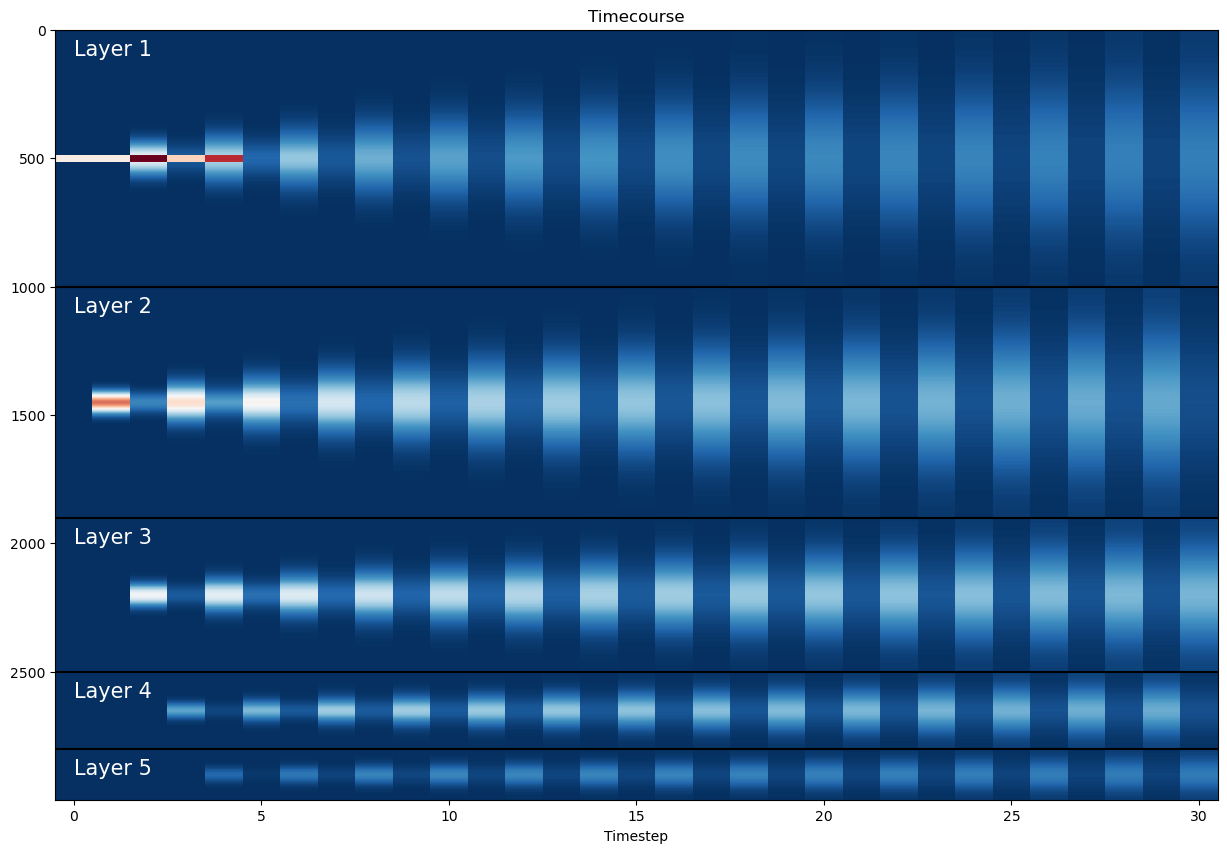

In [15]:
plt.imshow(np.asarray(timecourse).squeeze().T, origin = 'upper', aspect = 'auto', interpolation='none', cmap = 'RdBu_r')
plt.gcf().set_size_inches([15, 10])
plt.xlabel("Timestep")
plt.title("Timecourse")
for i in range(len(model.layer_sizes)):
    plt.hlines(y = np.sum(model.layer_sizes[:i]), xmin = -0.5, xmax = n_timesteps + .5, color = 'black')
    plt.text(x = 0, y = np.sum(model.layer_sizes[:i])+100, s = "Layer " + str(i+1), color = 'white', size = 15)

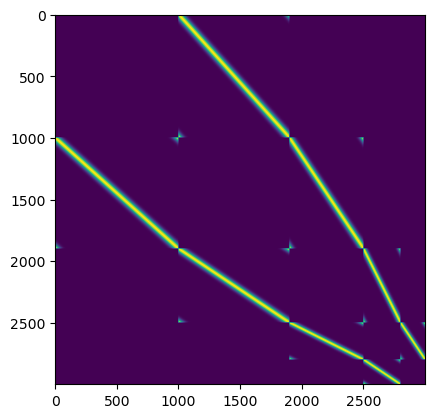

In [392]:
plt.imshow(model.W, vmax = 1, vmin = 0)